In [1]:
%cd /content/tph-yolov5

/content/tph-yolov5


In [2]:
from typing import Any, Dict, List, Optional

import torch
import numpy as np
from IPython.display import Image

from sahi.models.base import DetectionModel
from sahi.prediction import ObjectPrediction
from sahi.predict import get_prediction, get_sliced_prediction
from sahi.utils.compatibility import fix_full_shape_list, fix_shift_amount_list
from sahi.utils.import_utils import check_package_minimum_version, check_requirements

from models.experimental import attempt_load
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_coords

In [3]:
class TPHYolov5DetectionModel(DetectionModel):
    def check_dependencies(self) -> None:
        check_requirements(["torch", "yolov5"])

    def load_model(self):
        """
        Detection model is initialized and set to self.model.
        """
        model = attempt_load(self.model_path, map_location=self.device)
        model.eval()
        self.set_model(model)

    def set_model(self, model: Any):
        """
        Sets the underlying YOLOv5 model.
        Args:
            model: Any
                A YOLOv5 model
        """
        model.conf = self.confidence_threshold
        self.model = model

        # set category_mapping
        if not self.category_mapping:
            category_mapping = {str(ind): category_name for ind, category_name in enumerate(self.category_names)}
            self.category_mapping = category_mapping

    def perform_inference(self, image: np.ndarray):
        """
        Prediction is performed using self.model and the prediction result is set to self._original_predictions.
        Args:
            image: np.ndarray
                A numpy array that contains the image to be predicted. 3 channel image should be in RGB order.
        """
        # stride
        stride = int(self.model.stride.max())  # model stride
        # preprocess
        img = letterbox(image, self.image_size, stride=stride, auto=True)[0]
        img = img.transpose((2, 0, 1))  # [::-1]  # HWC to CHW, BGR to RGB
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img.float()  # uint8 to fp16/32
        img /= 255  # 0 - 255 to 0.0 - 1.0
        if len(img.shape) == 3:
            img = img[None]  # expand for batch dim

        # inference
        pred = self.model(img, augment=False, visualize=False)[0]
        # postprocess
        pred = non_max_suppression(pred, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, max_det=10000)
        det = pred[0]

        for det in pred:
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], image.shape).round()

        self._original_predictions = pred

    @property
    def num_categories(self):
        """
        Returns number of categories
        """
        return len(self.model.names)

    @property
    def category_names(self):
        return self.model.names

    def _create_object_prediction_list_from_original_predictions(
        self,
        shift_amount_list: Optional[List[List[int]]] = [[0, 0]],
        full_shape_list: Optional[List[List[int]]] = None,
    ):
        """
        self._original_predictions is converted to a list of prediction.ObjectPrediction and set to
        self._object_prediction_list_per_image.
        Args:
            shift_amount_list: list of list
                To shift the box and mask predictions from sliced image to full sized image, should
                be in the form of List[[shift_x, shift_y],[shift_x, shift_y],...]
            full_shape_list: list of list
                Size of the full image after shifting, should be in the form of
                List[[height, width],[height, width],...]
        """
        original_predictions = self._original_predictions

        # compatilibty for sahi v0.8.15
        shift_amount_list = fix_shift_amount_list(shift_amount_list)
        full_shape_list = fix_full_shape_list(full_shape_list)

        # handle all predictions
        object_prediction_list_per_image = []
        for image_ind, image_predictions_in_xyxy_format in enumerate(original_predictions):
            shift_amount = shift_amount_list[image_ind]
            full_shape = None if full_shape_list is None else full_shape_list[image_ind]
            object_prediction_list = []

            # process predictions
            for prediction in image_predictions_in_xyxy_format.cpu().detach().numpy():
                x1 = prediction[0]
                y1 = prediction[1]
                x2 = prediction[2]
                y2 = prediction[3]
                bbox = [x1, y1, x2, y2]
                score = prediction[4]
                category_id = int(prediction[5])
                category_name = self.category_mapping[str(category_id)]

                # fix negative box coords
                bbox[0] = max(0, bbox[0])
                bbox[1] = max(0, bbox[1])
                bbox[2] = max(0, bbox[2])
                bbox[3] = max(0, bbox[3])

                # fix out of image box coords
                if full_shape is not None:
                    bbox[0] = min(full_shape[1], bbox[0])
                    bbox[1] = min(full_shape[0], bbox[1])
                    bbox[2] = min(full_shape[1], bbox[2])
                    bbox[3] = min(full_shape[0], bbox[3])

                # ignore invalid predictions
                if not (bbox[0] < bbox[2]) or not (bbox[1] < bbox[3]):
                    print(f"ignoring invalid prediction with bbox: {bbox}")
                    continue

                object_prediction = ObjectPrediction(
                    bbox=bbox,
                    category_id=category_id,
                    score=score,
                    bool_mask=None,
                    category_name=category_name,
                    shift_amount=shift_amount,
                    full_shape=full_shape,
                )
                object_prediction_list.append(object_prediction)
            object_prediction_list_per_image.append(object_prediction_list)

        self._object_prediction_list_per_image = object_prediction_list_per_image

In [4]:
detection_model = TPHYolov5DetectionModel(
    model_path='/content/gdrive/MyDrive/2-專案/玉山-無人飛行載具計數/model/tph-yolov5l-xs_1100_1080_0.25_0.25/weights/best.pt',
    device='cuda',
    image_size=1280,
    mask_threshold=0.5,
    confidence_threshold=0.3
)

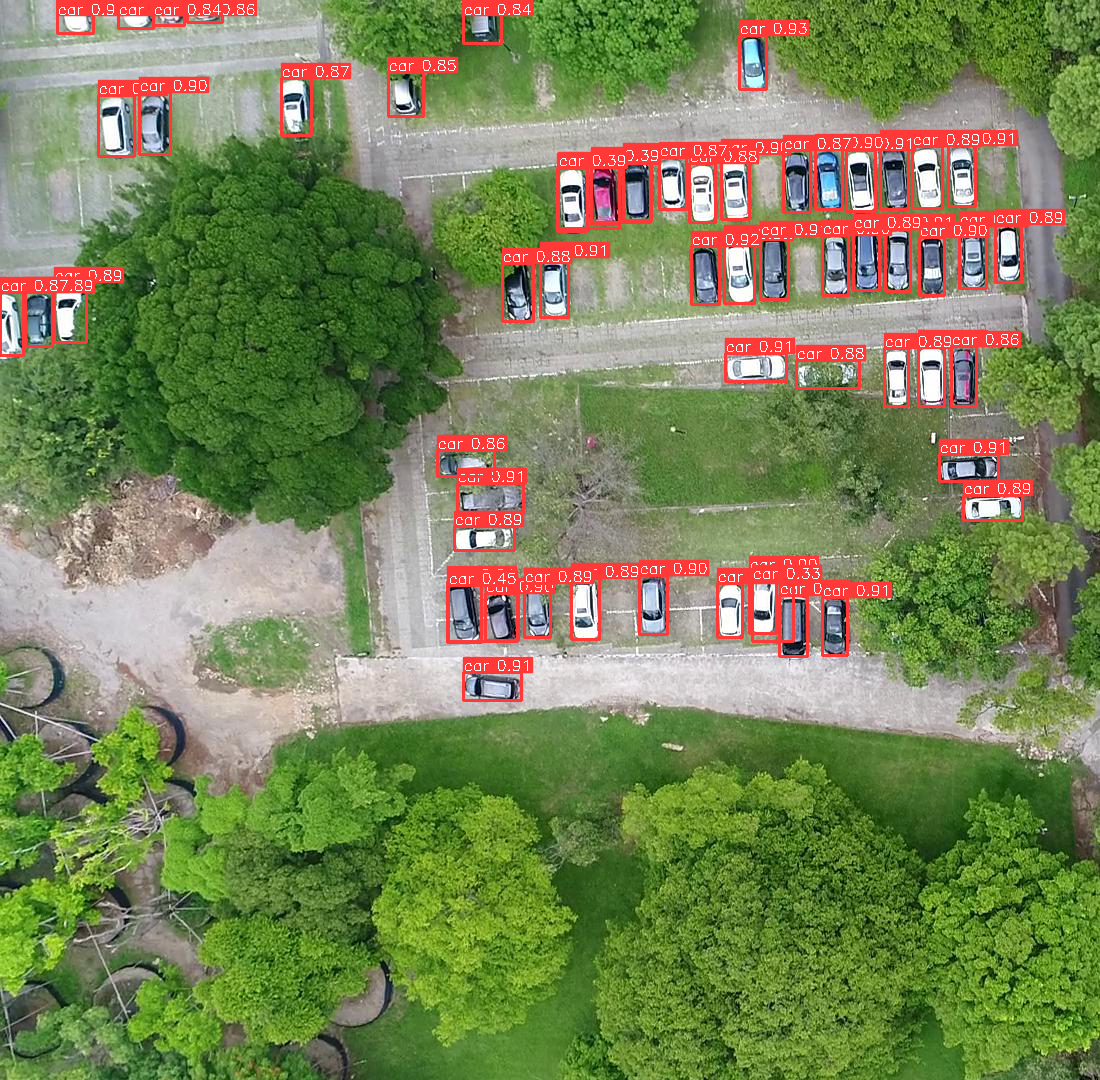

In [5]:
result = get_prediction(
    '/content/slice_coco_1100_1080_0.25_0.25/val/img0007_0_0_1100_1080.jpg',
    detection_model
)
result.export_visuals(export_dir='../demo_data/', text_size=0.5, rect_th=2)
Image('../demo_data/prediction_visual.png')

In [6]:
result = get_sliced_prediction(
    '/content/coco_t/val2017/img0095.png',
    detection_model,
    slice_height = 1080,
    slice_width = 1100,
    overlap_height_ratio = 0.25,
    overlap_width_ratio = 0.25
)

Performing prediction on 2 number of slices.


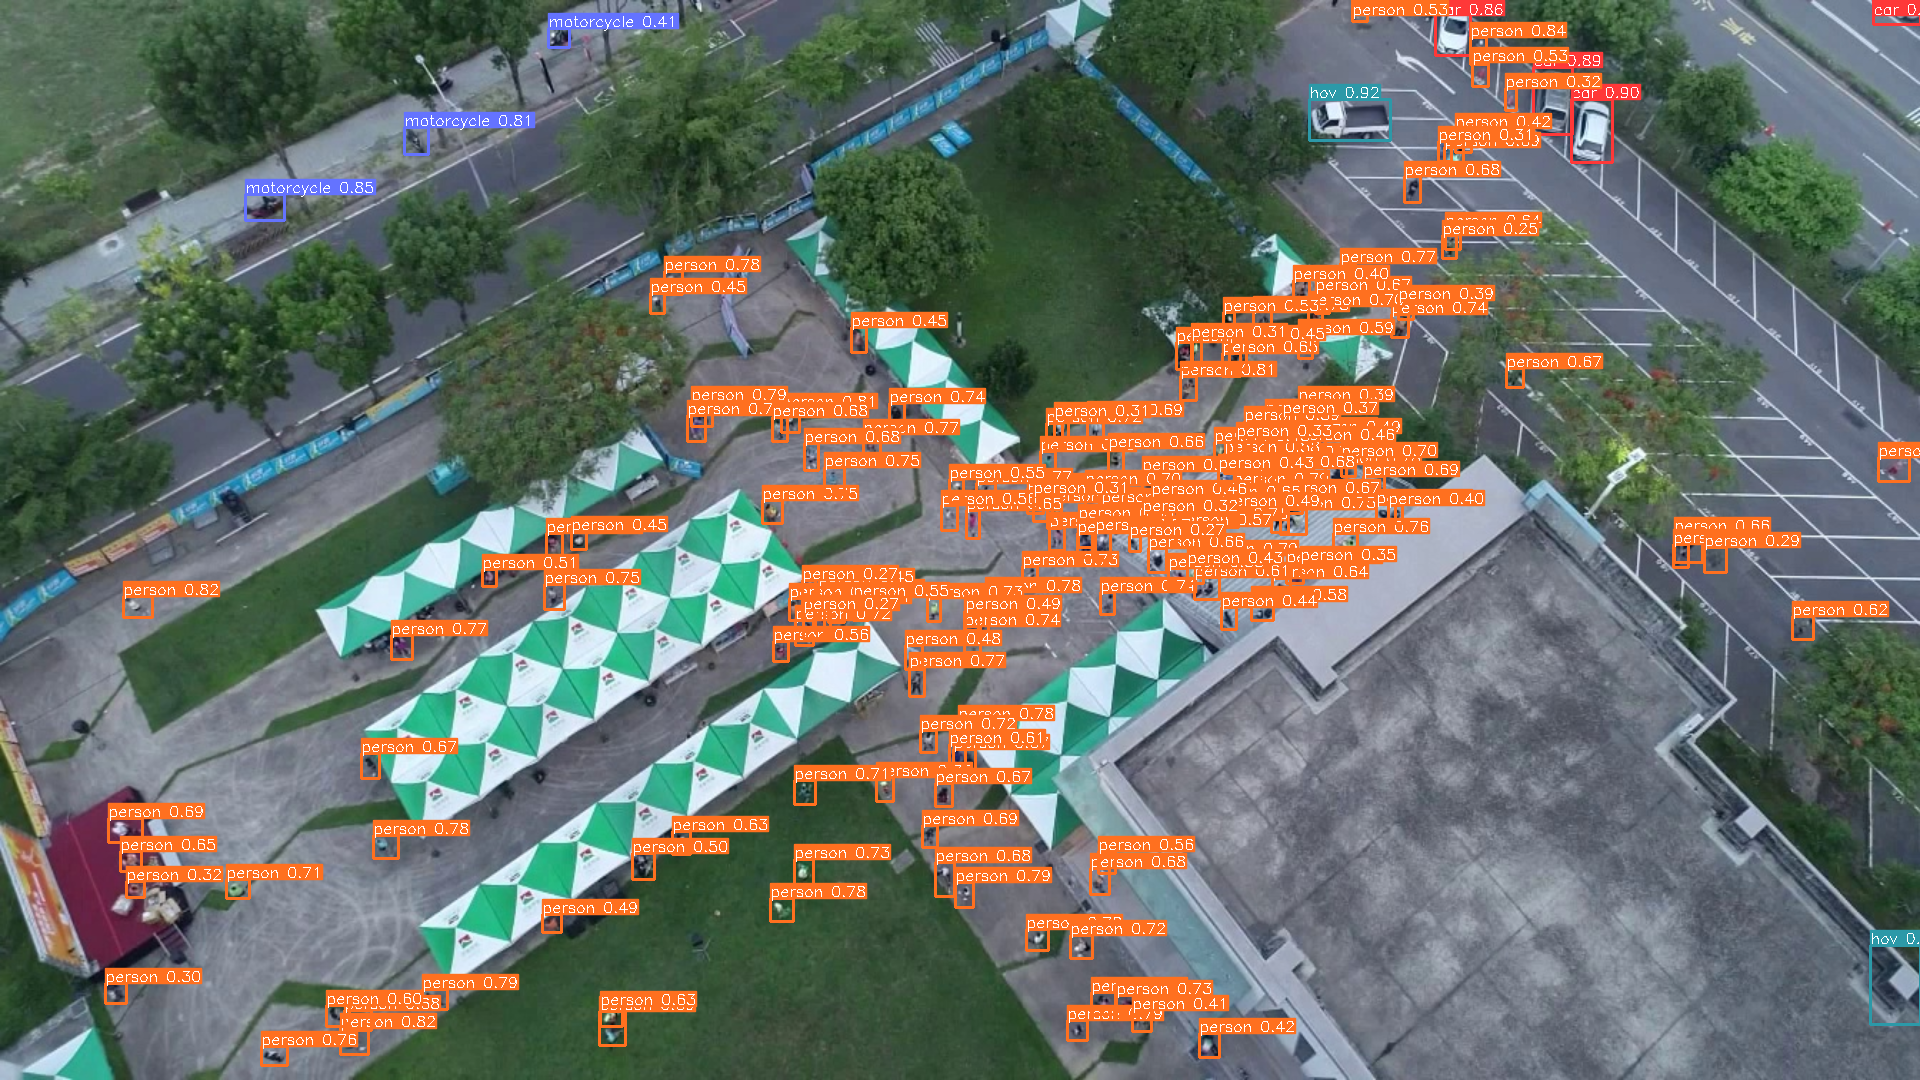

In [7]:
result.export_visuals(export_dir='../demo_data/', text_size=0.5, rect_th=2)
Image('../demo_data/prediction_visual.png')